# Step 1: Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 2: Read Dataset

In [2]:
df = pd.read_csv('car data.csv')  # Load the dataset from a CSV file into a DataFrame
df.head()  # Display the first 5 rows of the dataset

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


# Step 3: Dataset Overview

In [3]:
df.shape  # Returns the number of rows and columns in the DataFrame as a tuple (rows, columns)

(301, 9)

In [4]:
df.info()  # Displays summary information about the DataFrame, including column names, non-null counts, and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
# Generates summary statistics for all numeric columns and transposes the result for easier viewing
df.describe(include="number").T

,count,mean,std,min,25%,50%,75%,max
Year,301.0,2013.627907,2.891554,2003.00,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0


In [6]:
# Generates summary statistics for all object (categorical/text) columns and transposes the result
df.describe(include='object').T

,count,unique,top,freq
Car_Name,301,98,city,26
Fuel_Type,301,3,Petrol,239
Seller_Type,301,2,Dealer,195
Transmission,301,2,Manual,261


# Step 4: Data Preparation

#### 4.1 Drop car name

In [7]:
# Removes the 'Car_Name' column from the DataFrame in place
df.drop('Car_Name', axis=1, inplace=True)

#### 4.2 Explore and Transform Skewed Features

We examined the skewness of key numerical variables in the dataset:

- `Selling_Price`: 2.49
- `Present_Price`: 4.08
- `Kms_Driven`: 6.43

All three variables are highly right-skewed. This level of skewness can negatively impact the performance of linear models, which assume normally distributed features.

To address this:

- We applied a **logarithmic transformation** (`np.log1p`) to `Selling_Price` and `Present_Price`. This reduces the influence of extreme values and helps stabilize variance.
- Instead of transforming `Kms_Driven` numerically, we opted for **binning** it into categorical ranges. This allows the model to capture mileage effects more intuitively, especially in a dataset where kilometer values vary widely.

The `Kms_Driven` feature was binned into the following ranges:
- `0–20k`, `20k–50k`, `50k–100k`, `100k–150k`, and `150k+`

These categories were then one-hot encoded and the original `Kms_Driven` column was dropped.

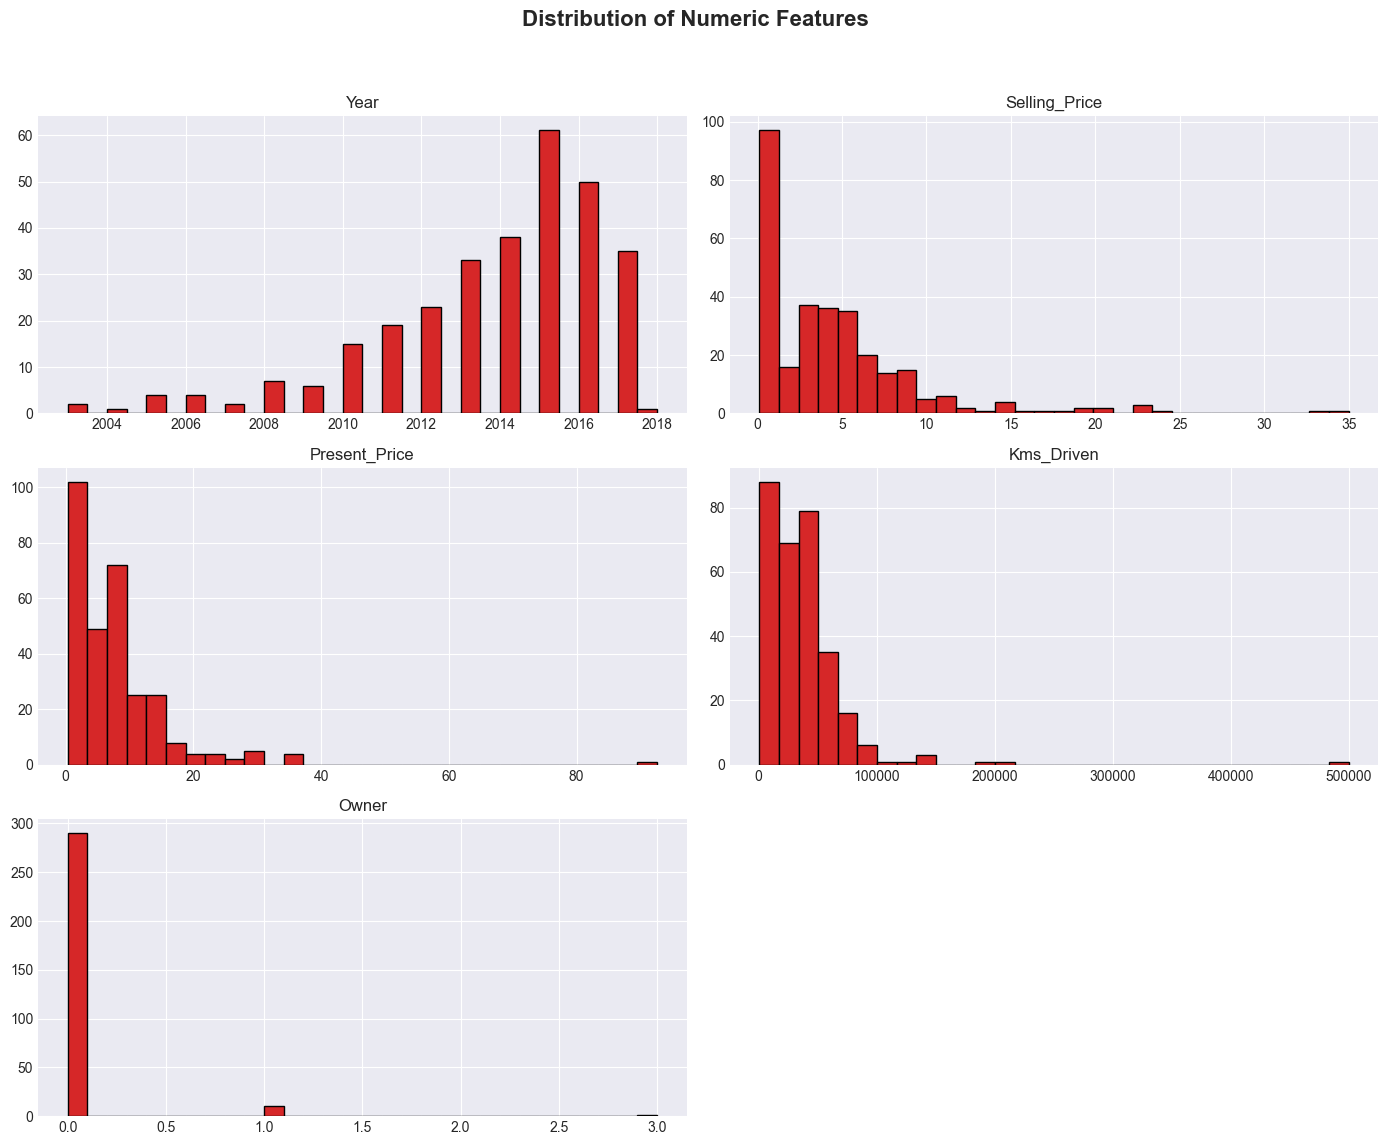

In [8]:
plt.style.use('seaborn-v0_8-darkgrid')

df.hist(
    figsize=(14, 12),
    bins=30,
    edgecolor='black',
    color='#D62728',
    grid=True
)

plt.suptitle('Distribution of Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
# Calculates the skewness of selected numeric columns
df[['Selling_Price', 'Present_Price', 'Kms_Driven']].skew()

Selling_Price    2.493422
Present_Price    4.083150
Kms_Driven       6.436013
dtype: float64

In [10]:
df['Selling_Price'] = np.log1p(df['Selling_Price'])  # Applies log(1 + x) transformation to reduce right skew in Selling_Price
df['Present_Price'] = np.log1p(df['Present_Price'])  # Applies log(1 + x) transformation to reduce right skew in Present_Price

In [11]:
# Define custom bins for 'Kms_Driven' and assign labels to each range
bins = [0, 20000, 50000, 100000, 150000, np.inf]
labels = ['0-20k', '20k-50k', '50k-100k', '100k-150k', '150k+']
df['Kms_Binned'] = pd.cut(df['Kms_Driven'], bins=bins, labels=labels)

# Convert the binned categories into dummy/one-hot encoded variables (drop_first avoids dummy variable trap)
df = pd.get_dummies(df, columns=['Kms_Binned'], drop_first=True)

# Drop the original 'Kms_Driven' column, since it's now represented in the binned dummies
df.drop('Kms_Driven', axis=1, inplace=True)

#### 4.3 Encode Categorical Variables 

In [12]:
# Converts categorical variables into dummy/one-hot encoded columns and drops the first category to avoid multicollinearity
df = pd.get_dummies(df, columns=['Fuel_Type', 'Seller_Type', 'Transmission'], drop_first=True)

#### 4.4 Feature Engineering: Create 'Age' from 'Year'

In [13]:
# The dataset includes a 'Year' column indicating the manufacturing year of each car.
# To make this feature more relevant for modeling, we convert it to 'Age' — the number of years since the car was manufactured.
# Since the dataset was published on Kaggle in 2020, we use 2020 as the reference year.
df['Age'] = 2020 - df['Year']  # Create 'Age' feature

# We drop the original 'Year' column because it is now represented by the new 'Age' feature.
df.drop('Year', axis=1, inplace=True)

#### 4.5 Final Dataset Preview

In [14]:
df.info() # Final overview of the dataset after data preparation; all features are cleaned, transformed, and ready for modeling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Selling_Price           301 non-null    float64
 1   Present_Price           301 non-null    float64
 2   Owner                   301 non-null    int64  
 3   Kms_Binned_20k-50k      301 non-null    bool   
 4   Kms_Binned_50k-100k     301 non-null    bool   
 5   Kms_Binned_100k-150k    301 non-null    bool   
 6   Kms_Binned_150k+        301 non-null    bool   
 7   Fuel_Type_Diesel        301 non-null    bool   
 8   Fuel_Type_Petrol        301 non-null    bool   
 9   Seller_Type_Individual  301 non-null    bool   
 10  Transmission_Manual     301 non-null    bool   
 11  Age                     301 non-null    int64  
dtypes: bool(8), float64(2), int64(2)
memory usage: 11.9 KB


# Step 5: Data Visualization

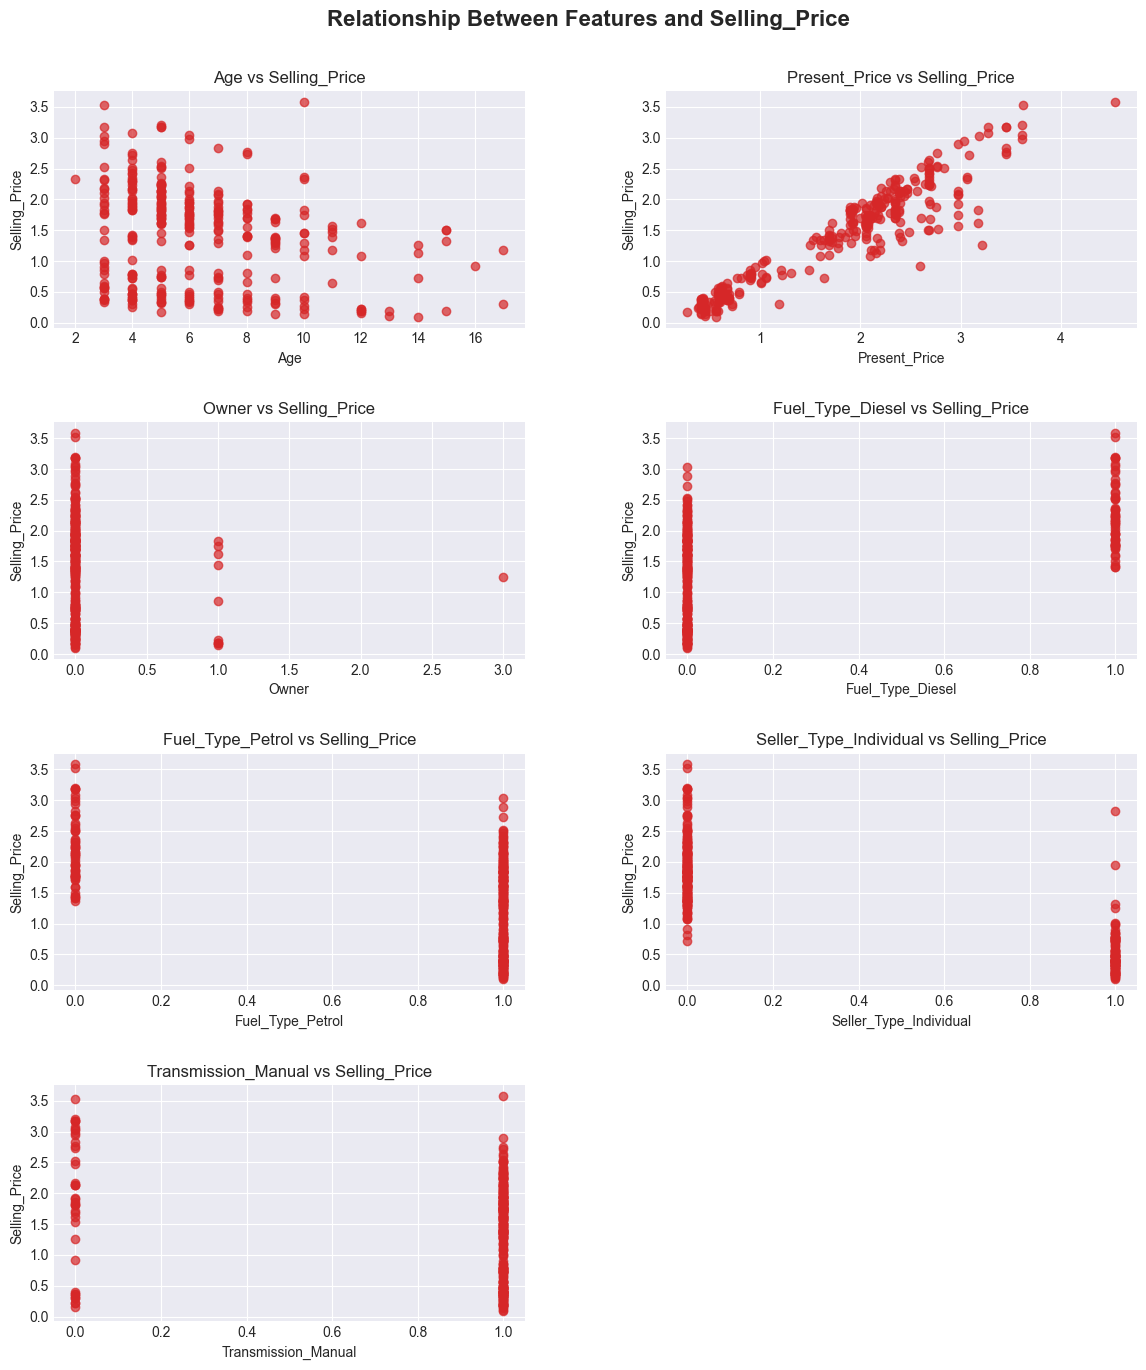

In [15]:
# Define a list of independent variables to analyze their relationship with Selling_Price
variables = ['Age', 'Present_Price', 'Owner', 
             'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 
             'Seller_Type_Individual', 'Transmission_Manual']

# Determine the layout for subplots (4 rows x 2 columns)
num_plots = len(variables)
num_rows = 4
num_cols = 2

# Create a figure with multiple subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 14))

# Add a main title for the figure
fig.suptitle('Relationship Between Features and Selling_Price', fontsize=16, fontweight='bold')

# Automatically adjust subplot spacing
fig.tight_layout(pad=3.0)

# Generate scatter plots for each feature against Selling_Price
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].scatter(df[var], df['Selling_Price'], color='#D62728', alpha=0.7)
    axs[row, col].set_xlabel(var)
    axs[row, col].set_ylabel('Selling_Price')
    axs[row, col].set_title(f'{var} vs Selling_Price')

# If the number of plots is less than the number of grid spaces, remove the unused axes
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

# Final adjustment of spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Display the full set of scatter plots
plt.show()

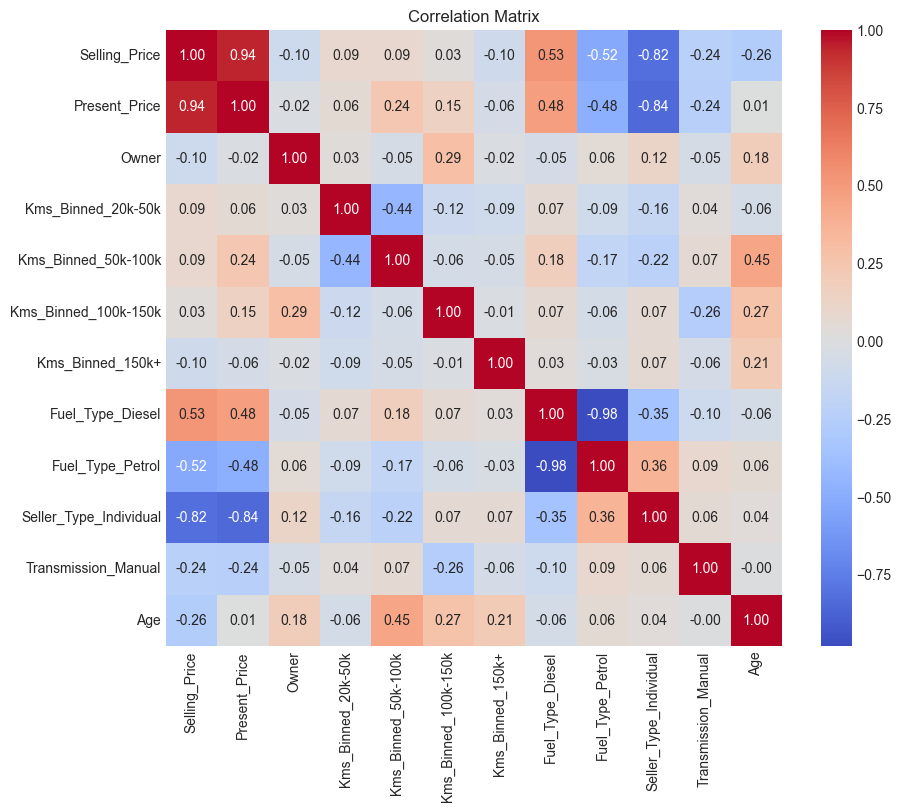

In [16]:
# Calculate the correlation matrix for all numeric features
corr_matrix = df.corr(numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

# Step 6: Model Training

In [17]:
# Define features (X) and target variable (y)
X = df.drop('Selling_Price', axis=1)  # All predictors
y = df['Selling_Price']  # Target: log-transformed selling price

In [18]:
# Split into training and test sets (10% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [19]:
# Train a Linear Regression model
model = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False
)

model.fit(X_train, y_train)

LinearRegression()

# Step 7: Model Evaluation

In [20]:
# Predict and evaluate model on test set
y_pred = model.predict(X_test)

In [21]:
# R²
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of predictors
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MSE
mse = mean_squared_error(y_test, y_pred)

# RMSE
rmse = np.sqrt(mse)

# Print all metrics
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.9790
Adjusted R²: 0.9668
MAE: 0.0857
MSE: 0.0129
RMSE: 0.1135


In [22]:
# Create a DataFrame to display model coefficients alongside their corresponding feature names
# This is useful to interpret the influence of each feature in the linear regression model

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

# Sort the DataFrame by coefficient values in descending order
# This helps to identify which features have the most positive or negative impact on the target variable
print(coef_df.sort_values(by='Coefficient', ascending=False))

                   Feature  Coefficient
0            Present_Price     0.767528
6         Fuel_Type_Diesel     0.325622
7         Fuel_Type_Petrol     0.137399
2       Kms_Binned_20k-50k    -0.045101
10                     Age    -0.059324
9      Transmission_Manual    -0.059954
1                    Owner    -0.093782
5         Kms_Binned_150k+    -0.094072
8   Seller_Type_Individual    -0.106581
3      Kms_Binned_50k-100k    -0.140638
4     Kms_Binned_100k-150k    -0.269328


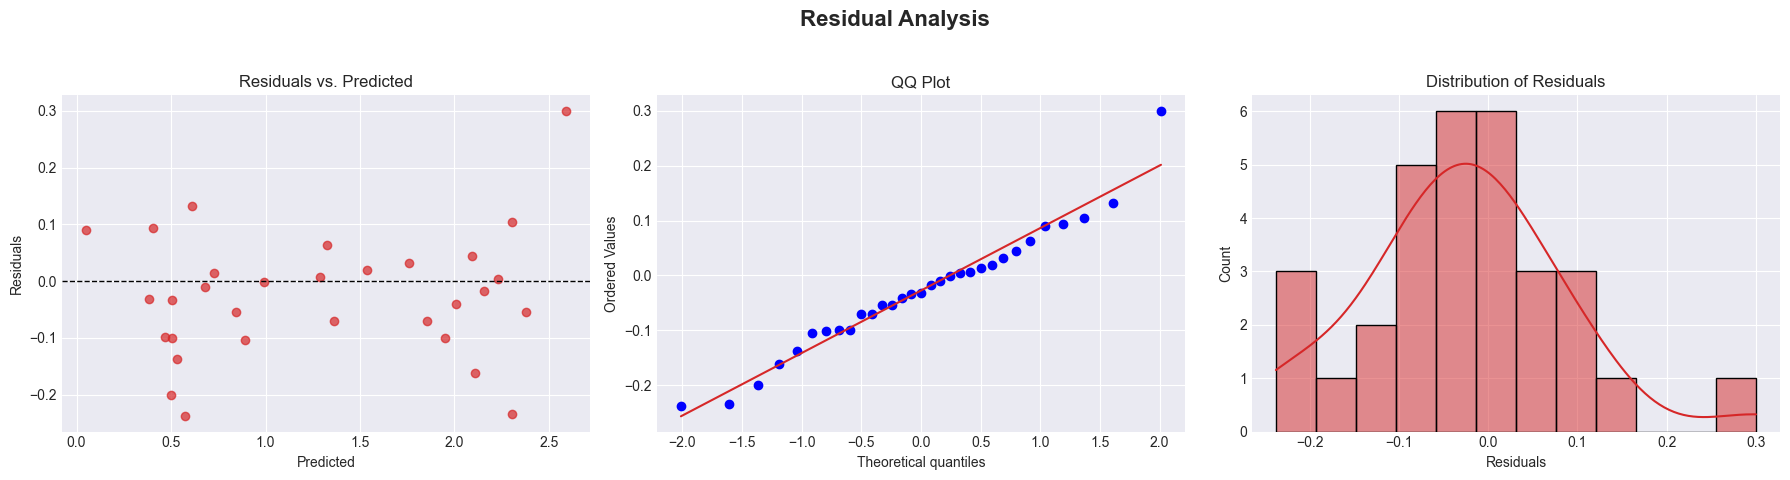

In [23]:
# Calculate residuals
residuals = y_test - y_pred

# Set up the layout for 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Residual Analysis", fontsize=16, fontweight='bold')

# Residuals vs. Predicted Values
axes[0].scatter(y_pred, residuals, alpha=0.7, color='#D62728')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs. Predicted")

# QQ Plot to assess normality of residuals
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].get_lines()[1].set_color('#D62728')  # QQ line
axes[1].set_title("QQ Plot")

# Histogram + KDE of residuals to visualize distribution
sns.histplot(residuals, kde=True, ax=axes[2], bins=12, color='#D62728', edgecolor='black')
axes[2].set_title("Distribution of Residuals")
axes[2].set_xlabel("Residuals")

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [24]:
# Ensure all features are of float type, as required by the VIF function
X = X.astype(float)

# Initialize a DataFrame to store VIF (Variance Inflation Factor) values
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns

# Calculate VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_df)

                   Feature        VIF
0            Present_Price  20.401427
1                    Owner   1.172922
2       Kms_Binned_20k-50k   2.956735
3      Kms_Binned_50k-100k   2.951605
4     Kms_Binned_100k-150k   1.552977
5         Kms_Binned_150k+   1.188052
6         Fuel_Type_Diesel  10.801448
7         Fuel_Type_Petrol  32.979624
8   Seller_Type_Individual   5.924126
9      Transmission_Manual   8.132478
10                     Age  10.835498


# Step 8: Addressing Multicollinearity

To assess the presence of multicollinearity among the features, we calculated in Step 7 the Variance Inflation Factor (VIF) for each variable.

Multicollinearity occurs when two or more independent variables are highly correlated with each other, which can inflate the variance of coefficient estimates in a linear regression model.

#### Why multicollinearity is suspected:
- The correlation matrix (see Step 7) showed a very strong negative correlation between `Fuel_Type_Diesel` and `Fuel_Type_Petrol` (-0.98), which is expected given that they are one-hot encoded representations of a single categorical variable.
- The VIF values confirm this suspicion:
  - `Fuel_Type_Petrol`: **32.98**
  - `Fuel_Type_Diesel`: **10.80**
  - `Present_Price`: **20.40**
  - `Age`: **10.83**
  - `Transmission_Manual`: **8.13**

High VIF values (generally > 10) indicate that multicollinearity is likely present and could affect the stability of coefficient estimates.

#### Important note on prediction:
> While multicollinearity inflates coefficient variance and can make interpretation unreliable, it does **not** necessarily reduce the predictive power of the model. For this reason, it is not a critical issue when the goal is prediction rather than inference.

In this case, due to the very high VIF between fuel type variables, it may be helpful to drop one of them or combine them if interpretability is a priority.

**Action taken:** we dropped the `Fuel_Type_Diesel` column to reduce multicollinearity, while retaining `Fuel_Type_Petrol` as the representative dummy variable for fuel type.

In [25]:
df_treated = df.drop(["Fuel_Type_Diesel"], axis=1)

In [26]:
# Define features (X) and target variable (y)
X_treated = df_treated.drop('Selling_Price', axis=1)  # All predictors
y_treated = df_treated['Selling_Price']  # Target: log-transformed selling price

In [27]:
# Split into training and test sets (10% for testing)
X_train_treated, X_test_treated, y_train_treated, y_test_treated = train_test_split(X_treated,
                                                                                    y_treated,
                                                                                    test_size=0.10,
                                                                                    random_state=42)

In [28]:
# Train a Linear Regression model
model_treated = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False
)

model_treated.fit(X_train_treated, y_train_treated)

LinearRegression()

In [29]:
# Predict and evaluate model on test set
y_pred_treated = model_treated.predict(X_test_treated)

In [30]:
# R²
r2_treated = r2_score(y_test_treated, y_pred_treated)

# Adjusted R²
n = X_test_treated.shape[0]  # number of observations
p = X_test_treated.shape[1]  # number of predictors
adj_r2_treated = 1 - ((1 - r2_treated) * (n - 1)) / (n - p - 1)

# MAE
mae_treated = mean_absolute_error(y_test_treated, y_pred_treated)

# MSE
mse_treated = mean_squared_error(y_test_treated, y_pred_treated)

# RMSE
rmse_treated = np.sqrt(mse_treated)

# Print all metrics
print(f"R²: {r2_treated:.4f}")
print(f"Adjusted R²: {adj_r2_treated:.4f}")
print(f"MAE: {mae_treated:.4f}")
print(f"MSE: {mse_treated:.4f}")
print(f"RMSE: {rmse_treated:.4f}")

R²: 0.9795
Adjusted R²: 0.9693
MAE: 0.0843
MSE: 0.0125
RMSE: 0.1120


In [31]:
coef_df_treated = pd.DataFrame({'Feature': X_treated.columns, 'Coefficient': model_treated.coef_})
print(coef_df_treated.sort_values(by='Coefficient', ascending=False))

                  Feature  Coefficient
0           Present_Price     0.774618
2      Kms_Binned_20k-50k    -0.045054
9                     Age    -0.060484
8     Transmission_Manual    -0.061563
5        Kms_Binned_150k+    -0.080827
1                   Owner    -0.093550
7  Seller_Type_Individual    -0.094879
3     Kms_Binned_50k-100k    -0.131165
6        Fuel_Type_Petrol    -0.170872
4    Kms_Binned_100k-150k    -0.265660


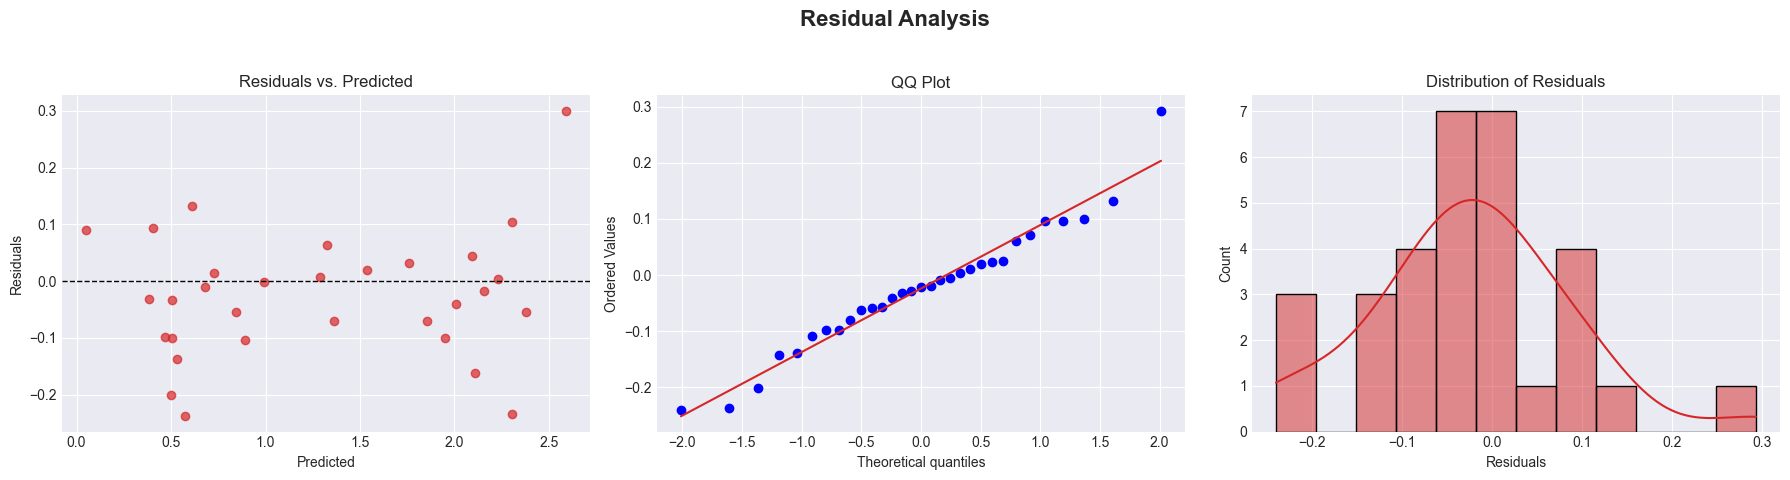

In [32]:
# Calculate residuals
residuals_treated = y_test_treated - y_pred_treated

# Set up the layout for 3 subplots side by side
fig_treated, axes_treated = plt.subplots(1, 3, figsize=(18, 5))
fig_treated.suptitle("Residual Analysis", fontsize=16, fontweight='bold')

# Residuals vs. Predicted Values
axes_treated[0].scatter(y_pred, residuals, alpha=0.7, color='#D62728')
axes_treated[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes_treated[0].set_xlabel("Predicted")
axes_treated[0].set_ylabel("Residuals")
axes_treated[0].set_title("Residuals vs. Predicted")

# QQ Plot to assess normality of residuals
stats.probplot(residuals_treated, dist="norm", plot=axes_treated[1])
axes_treated[1].get_lines()[1].set_color('#D62728')  # QQ line
axes_treated[1].set_title("QQ Plot")

# Histogram + KDE of residuals to visualize distribution
sns.histplot(residuals_treated, kde=True, ax=axes_treated[2], bins=12, color='#D62728', edgecolor='black')
axes_treated[2].set_title("Distribution of Residuals")
axes_treated[2].set_xlabel("Residuals")

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [33]:
X_treated = X_treated.astype(float)

vif_df_treated = pd.DataFrame()
vif_df_treated["Feature"] = X_treated.columns
vif_df_treated["VIF"] = [variance_inflation_factor(X_treated.values, i) for i in range(X_treated.shape[1])]
print(vif_df_treated)

                  Feature        VIF
0           Present_Price   5.799419
1                   Owner   1.161128
2      Kms_Binned_20k-50k   2.897180
3     Kms_Binned_50k-100k   2.951107
4    Kms_Binned_100k-150k   1.527105
5        Kms_Binned_150k+   1.185698
6        Fuel_Type_Petrol   5.349693
7  Seller_Type_Individual   3.030119
8     Transmission_Manual   6.576891
9                     Age  10.697508
